In [326]:
import timeit
import random
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

L = 6 #половина того, что может храниться в одной ноде

def key_value_list(node): #функция возвращает массив листов дерева
    if node.type!='data':
        res = []
        for node_ in node.nodes:
            res = res + key_value_list(node_)
        return(res)
    else:
        tmp = []
        for data in node.data:
            if data[2] == False:
                tmp.append(data)
        return tmp
        
def rootfixing(tmp): #В случае если из корня выходит больше 2L нод, нужно добавить еще 1 уровень с тремя нодами,
    #подцепив все остальные ноды к ним
    dtn = [Page_node(tmp),Page_node(tmp),Page_node(tmp)]
    dtn[0].nodes = tmp.nodes[:L]
    dtn[1].nodes = tmp.nodes[:-L][L:]
    dtn[2].nodes = tmp.nodes[-L:]
    for i in range(3):#каждой из 3 созданых нод укажем, что корень - ее родитель, дипазон ключей и количество нод потомков
        dtn[i].num_data_or_nodes = len(dtn[i].nodes)
        dtn[i].keys = (dtn[i].nodes[0].keys[0],dtn[i].nodes[dtn[i].num_data_or_nodes-1].keys[1])
        dtn[i].parent = tmp
        for node in dtn[i].nodes:
            node.parent = dtn[i]
    tmp.nodes = []
    for i in range(3):
        tmp.nodes.append(dtn[i])
    
    tmp.num_data_or_nodes = 3
    
def upgoing(node):#если после добовления пары ключ-значение в ноде больше 2L данных, то вызывается функция,
    #которая пройдется вверх по дереву и пофиксит эту проблему
    tmp = node
    while 1:
        if tmp.num_data_or_nodes > 2*L and tmp.type == 'root':#если из корня выходит больше 2L нод - ыиксим его
            rootfixing(tmp)
            break
        if tmp.num_data_or_nodes <= 2*L:#если в ходе движения вверх и устранения проблемы, проблемы кончились, то прекращаем
            break
        if tmp.num_data_or_nodes > 2*L and tmp.type != 'root':#если нода не корень, но в ней слишком много содержимого - 
            #делим ее
            tmp = split(tmp)
def rebuild_tree(node):#перестраиваем дерево при превышении количества дочерних нод
    upgoing(node)
def split(tmp): #функция, делящая содержимое ноды на 3
    if tmp.type == 'data': #если это нода, хранящая непосредственно данные
        dtn = [Data_node(tmp.parent),Data_node(tmp.parent),Data_node(tmp.parent)]
        dtn[0].data = tmp.data[:L]
        dtn[1].data = tmp.data[:-L][L:]
        dtn[2].data = tmp.data[-L:]
        for i in range(3):
            dtn[i].num_data_or_nodes = len(dtn[i].data)
            dtn[i].keys = (dtn[i].data[0][0],dtn[i].data[len(dtn[i].data) - 1][0])
        for i in range(len(tmp.parent.nodes)):
            if tmp.parent.nodes[i] == tmp:
                break
        tmp.parent.nodes[i] = dtn[0]
        tmp.parent.nodes.insert(i+1,dtn[1])
        tmp.parent.nodes.insert(i+2,dtn[2])
        tmp.parent.num_data_or_nodes += 2
        return tmp.parent
    else: #если это нода, хранящая страницы
        dtn = [Page_node(tmp.parent),Page_node(tmp.parent),Page_node(tmp.parent)]
        dtn[0].nodes = tmp.nodes[:L]
        dtn[1].nodes = tmp.nodes[:-L][L:]
        dtn[2].nodes = tmp.nodes[-L:]
        for i in range(3):
            dtn[i].num_data_or_nodes = len(dtn[i].nodes)
            dtn[i].keys = (dtn[i].nodes[0].keys[0],dtn[i].nodes[dtn[i].num_data_or_nodes-1].keys[1])
            for node in dtn[i].nodes:
                node.parent = dtn[i]
        for i in range(len(tmp.parent.nodes)):
            if tmp.parent.nodes[i] == tmp:
                break
        tmp.parent.nodes[i] = dtn[0]
        tmp.parent.nodes.insert(i+1,dtn[1])
        tmp.parent.nodes.insert(i+2,dtn[2])
        tmp.parent.num_data_or_nodes += 2
        return tmp.parent
            
class Page_node(object): #класс для ноды, у которой есть потомки
        def __init__(self,parent = None):
            self.nodes = None
            self.type = 'page'
            self.parent = parent
class Data_node(object): #класс для ноды, в которой хранится массив с парми ключ - значение
        def __init__(self,parent = None):
            self.data = None
            self.type = 'data'
            self.parent = parent
class BTree_root(object): #корень дерева
    
    def __init__(self):
        self.nodes = None
        self.type = 'root'
    
    def merge(self,tree):#объединение 2 деревьев
        list2 = key_value_list(self)#получаем списки пар ключ-значение из обоих деревьев
        list1 = key_value_list(tree)
        res = []
        i = 0
        j = 0
        while (i < len(list1)) or (j < len(list2)):#сливаем их в  1 список
            if (i < len(list1)) and (j < len(list2)):
                if list1[i] < list2[j]:
                    res.append(list1[i])
                    i += 1
                else:
                    res.append(list2[j])
                    j += 1
                continue 
            else:
                if i < len(list1):
                    res.append(list1[i])
                    i += 1
                else:
                    res.append(list2[j])
                    j += 1
        data_nodes = []
        while 1: #а теперь объединяем их в группы, до тех пор, пока размер верхнего яруса не окажется в пределах L - 2L
            if len(res) >  L:
                tmp = Data_node()
                tmp.data = res[:L]
                tmp.num_data_or_nodes = L
                tmp.keys = (tmp.data[0][0],tmp.data[len(tmp.data)-1][0])
                res = res[L:]
                data_nodes.append(tmp)
                continue
            else:
                tmp = Data_node()
                tmp.data = res
                tmp.num_data_or_nodes = len(res)
                tmp.keys = (tmp.data[0][0],tmp.data[len(tmp.data)-1][0])
                data_nodes.append(tmp)
                break
        tmp = data_nodes    
        while 1:
            if len(tmp) < 2*L:
                root = BTree_root()
                root.num_data_or_nodes = len(tmp)
                root.nodes = tmp
                root.keys = (root.nodes[0].keys[0],root.nodes[len(root.nodes)-1].keys[1])
                for node in root.nodes:
                    node.parent = root
                return root
            else:
                data_nodes = []
                while 1:
                    if len(tmp) >  L:
                        tmp_ = Page_node()
                        tmp_.nodes = tmp[:L]
                        tmp_.num_data_or_nodes = L
                        tmp = tmp[L:]
                        tmp_.keys = (tmp_.nodes[0].keys[0],tmp_.nodes[len(tmp_.nodes)-1].keys[1])
                        data_nodes.append(tmp_)
                        for node in tmp_.nodes:
                            node.parent = tmp_
                        continue
                    else:
                        tmp_ = Page_node()
                        tmp_.nodes = tmp
                        tmp_.num_data_or_nodes = len(tmp)
                        tmp_.keys = (tmp_.nodes[0].keys[0],tmp_.nodes[len(tmp_.nodes)-1].keys[1])
                        data_nodes.append(tmp_)
                        tmp = data_nodes
                        for node in tmp_.nodes:
                            node.parent = tmp_
                        
                        break
            
            
    
    def add_data(self,key,value):#добавляем в дерево пару ключ - значение
        self.type = 'root'
        if self.nodes == None:#случай, когда в дерево еще не вносились данные
            self.nodes = []
            self.nodes.append(Page_node(self))
            self.nodes[0].nodes = []
            self.nodes[0].nodes.append(Data_node(self.nodes[0]))
            self.nodes[0].nodes[0].data = []
            self.nodes[0].nodes[0].data.append([key,value,False])
            self.nodes[0].nodes[0].num_data_or_nodes = 1
            self.nodes[0].nodes[0].keys = (key,key)
            self.nodes[0].num_data_or_nodes = 1
            self.nodes[0].keys = (key,key)
            self.num_data_or_nodes = 1
            self.keys = (key,key)
        else:#случай, когда в дереве уже что-то есть
            tmp = self
            tmp.keys = (min(tmp.keys[0],key),max(tmp.keys[1],key)) 
            while(1): #спускаемся к вершинам, для добавления нового жлемента
                if tmp.type != 'data':
                    for node in tmp.nodes:
                        if key < node.keys[1]:
                            break
                    tmp = node
                    tmp.keys = (min(tmp.keys[0],key),max(tmp.keys[1],key)) 
                    #обновляем диапазон ключей, хранимых под этой вершиной
                else:
                    check = 0
                    
                    for i in range(len(tmp.data)): #добравшись до вершины, вставляем данные в правильное место
                        if tmp.data[i][0] == key:
                            if not tmp.data[i][2]:
                                break
                            else:
                                
                                tmp.data[i] = [key,value,False]
                                break
                        if tmp.data[i][0] > key:
                            check = 1
                            break
                    if tmp.data[i] == [key,value,False]:
                        break
                    if check == 0:
                        tmp.data.append([key,value,False]) 
                    else:
                        tmp.data.insert(i,[key,value,False])  
                    tmp.num_data_or_nodes+=1
                    break
            if tmp.num_data_or_nodes > 2 * L: #после вставки проверяем, не превышен ли лимит для данной ноды
                rebuild_tree(tmp)
    def remove_data(self,key): #поместим маркер удаления по с ключу в дерево             
        if self.nodes == None: 
            pass#нельзя удалить что-то из пустого дерева
        else:
            tmp = self
            while(1):
                if tmp.type != 'data':
                    for node in tmp.nodes:
                        if key < node.keys[1]:
                            break
                    tmp = node
                else:
                    check = 0
                    for i in range(len(tmp.data)):
                        if tmp.data[i][0] == key:
                            check = 1
                            if tmp.data[i][2] == True:
                                pass
                            else:
                                tmp.data[i][2] = True
                            break
                    if check == 0:
                        pass
                    break
    def find(self,key):
        if self.nodes == None:   #нельзя найти что-то в пустом дереве
            pass
        else:
            tmp = self
            while(1):
                if tmp.type != 'data':
                    for node in tmp.nodes:
                        if key <= node.keys[1]:
                            break
                    tmp = node
                else:
                    check = 0
                    for i in range(len(tmp.data)):
                        if tmp.data[i][0] == key:
                            check = 1
                            if tmp.data[i][2] == True:
                                pass
                            else:
                                return(tmp.data[i][1])
                            break
                    if check == 0:
                        pass
                    break
                    






TEST 1 : Добавление данных. Добавим в дерево некоторое количество данных, затем добавим еще 1 значение, попробуем его найти и удалить

In [327]:
root = BTree_root()

for i in range(1000):
    root.add_data(int(random.random()*10**64),int(random.random()*10**64))
for_search = int(random.random()*10**64)
root.add_data(for_search,for_search)
print(root.find(for_search))
root.remove_data(for_search)
print(root.find(for_search))
root.add_data(for_search,for_search)
print(root.find(for_search))

5867864687578383338329273959761275087742627231124807778738110464
None
5867864687578383338329273959761275087742627231124807778738110464


Test 2: смерджим 2 дерева, а затем убедимся в присутсвии в новом дереве элементов старого:

In [328]:
root1 = BTree_root()
root2 = BTree_root()

for i in range(1000):
    root1.add_data(int(random.random()*10**64),int(random.random()*10**64))
    root2.add_data(int(random.random()*10**64),int(random.random()*10**64))
for_search1 = int(random.random()*10**64)
for_search2 = int(random.random()*10**64)
root1.add_data(for_search1,for_search1)    
root2.add_data(for_search2,for_search2)      
print(for_search1)
print(for_search2)
root = root1.merge(root2)

print(root.find(for_search1))
print(root.find(for_search2))

2060779460276070012086549033329954560553813933842558999397924864
4681428978649897362206395270378161622873732104169865129588948992
2060779460276070012086549033329954560553813933842558999397924864
4681428978649897362206395270378161622873732104169865129588948992


Test 3: мерим время вставки в дерево

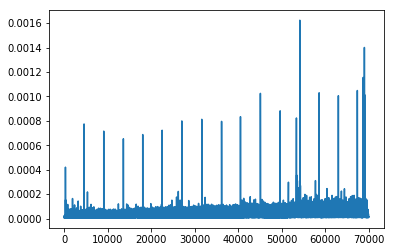

In [330]:
root3 = BTree_root()
time = []
lenn = []
for i in range(70000):
    a = timeit.default_timer()
    root3.add_data(int(random.random()*10**64),int(random.random()*10**64))
    time.append(timeit.default_timer()-a)
    lenn.append(i+1)
    
df = pd.DataFrame({'insert_num':lenn,'time':time})
plt.plot(df['insert_num'],df['time'])

Это график врмени одной вставки от суммарного количества вставок. Периодические всплески - перестроения дерева